# Integrating data using `sc.tl.ingest`

In [62]:
import scanpy as sc
import pandas as pd
import seaborn as sns

In [2]:
sc.settings.verbosity = 1             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80, frameon=False)

/Users/alexwolf/miniconda3/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


scanpy==1.4.5.dev220+g369555a anndata==0.7rc2.dev9+g5928e64 umap==0.3.8 numpy==1.16.3 scipy==1.3.0 pandas==0.25.3 scikit-learn==0.22 statsmodels==0.10.0 python-igraph==0.7.1 louvain==0.6.1


## PBMCs

We consider an annotated reference dataset `adata_ref` and a dataset for which you want to query labels and embeddings `adata`.

In [13]:
adata_ref = sc.datasets.pbmc3k_processed()  # this is an earlier version of the dataset from the pbmc3k tutorial
adata = sc.datasets.pbmc68k_reduced()

To use `sc.tl.ingest`, the datasets need to be defined on the same variables.

In [14]:
var_names = adata_ref.var_names.intersection(adata.var_names)
adata_ref = adata_ref[:, var_names].copy()
adata = adata[:, var_names].copy()

The model and graph (here PCA, neighbors, UMAP) trained on the reference data will explain the biological variation observed within it.

In [15]:
sc.pp.pca(adata_ref)
sc.pp.neighbors(adata_ref)
sc.tl.umap(adata_ref)

The manifold still looks essentially the same as in the [clustering tutorial](https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html).

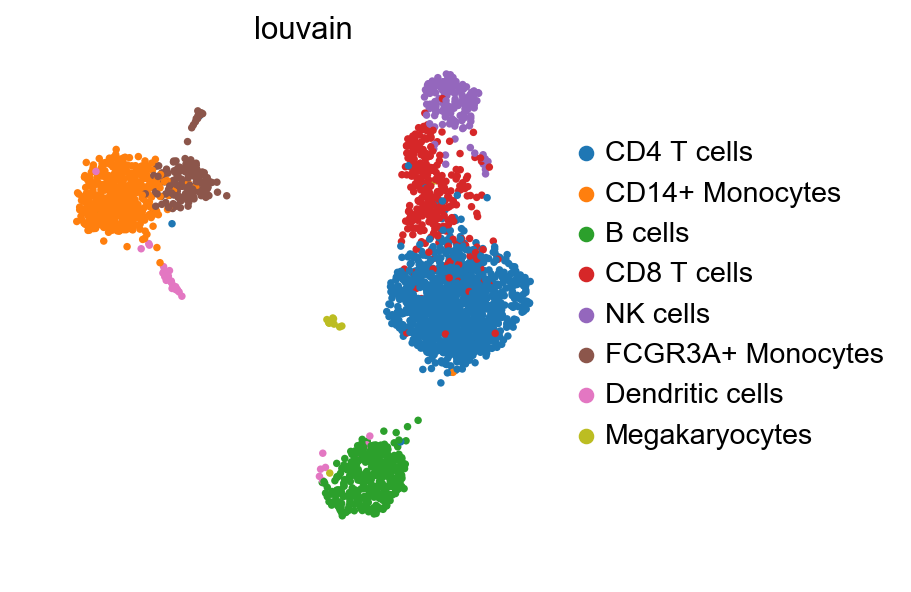

In [17]:
sc.pl.umap(adata_ref, color='louvain')

### Mapping PBMCs

Let's map labels and embeddings from `adata_ref` to `adata` based on a chosen representation. Here, we use `adata_ref.obsm['X_pca']` to map cluster labels and the UMAP coordinates.

<div class="alert alert-info">
    
**Note**
    
We refer to this *asymmetric* dataset integration as *ingesting* annotations from reference data to new data. This is different from learning a joint representation that integrates both datasets in an unbiased way, as CCA (e.g. in Seurat) or a conditional VAE (e.g. in scVI) would do.
    
<div>

In [18]:
sc.tl.ingest(adata, adata_ref, obs='louvain')

In [19]:
adata.uns['louvain_colors'] = adata_ref.uns['louvain_colors']  # fix colors

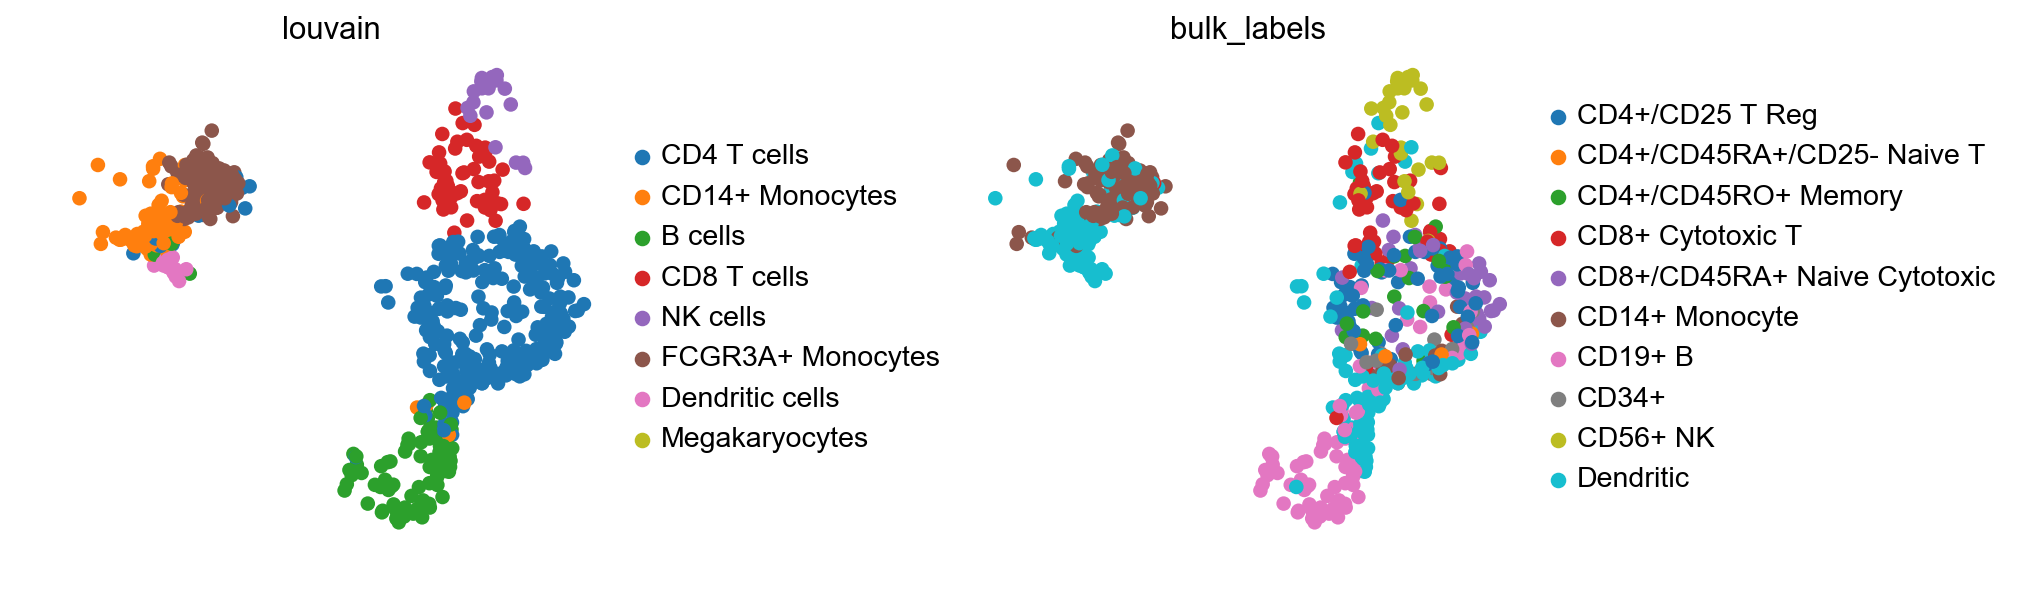

In [21]:
sc.pl.umap(adata, color=['louvain', 'bulk_labels'], wspace=0.5)

By comparing the 'bulk_labels' annotation with 'louvain', we see that the data has been reasonably mapped, only the annotation of dendritic cells seems ambiguous and might have been ambiiguous in `adata` already.

### The concatenated adata

In [22]:
adata_concat = adata_ref.concatenate(adata, batch_categories=['ref', 'new'])

... storing 'bulk_labels' as categorical
... storing 'louvain' as categorical
... storing 'phase' as categorical


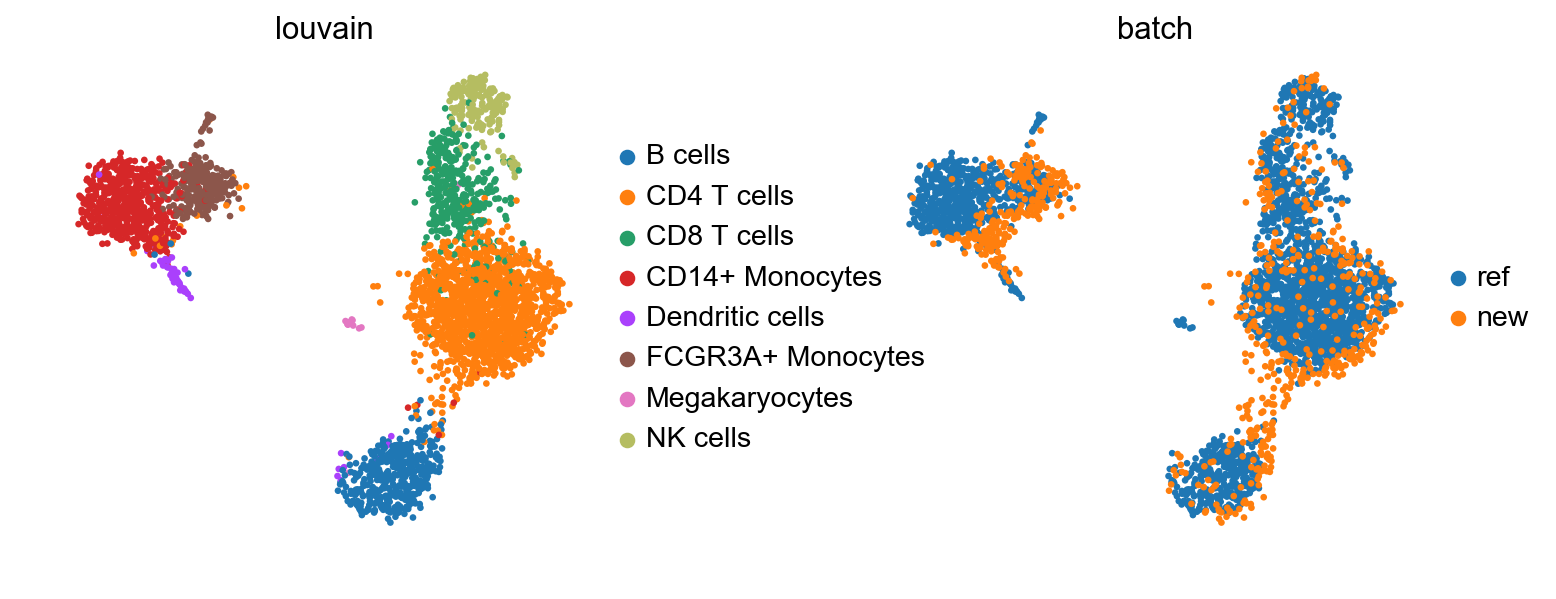

In [23]:
sc.pl.umap(adata_concat, color=['louvain', 'batch'], wspace=0.4)

While there seems to be some batch-effect in the monocytes and dendritic cell clusters, the new data is otherwise mapped relatively homogeneously.

The megakaryoctes are only present in `adata_ref` and no cells from `adata` map onto them. If interchanging reference data and query data, Megakaryocytes do not appear as a separate cluster anymore. This is an extreme case as the reference data is very small; but one should always question if the reference data contain enough biological variation to meaningfully accomodate query data.

## Pancreas

The following data has been used in the scGen paper [(Lotfollahi *et al.*, 2019)](https://doi.org/10.1038/s41592-019-0494-8), has been curated [here](https://nbviewer.jupyter.org/github/M0hammadL/scGen_notebooks/blob/master/notebooks/scgen_batch_removal.ipynb), and was originally downloaded from [here](ftp://ngs.sanger.ac.uk/production/teichmann/BBKNN/objects-pancreas.zip).

It contains data for human pancreas from 4 different studies (Segerstolpe16, Baron16, Wang16, Muraro16), which have been used in the seminal papers on single-cell dataset integration (Butler18, Haghverdi18) and many times ever since.

In [26]:
adata_all = sc.read(  # note that this collection of batches is already intersected on the genes
    'data/pancreas.h5ad',
    backup_url='https://www.dropbox.com/s/qj1jlm9w10wmt0u/pancreas.h5ad?dl=1'
)

In [27]:
adata_all.shape

(14693, 2448)

Inspect the cell types observed in these studies.

In [28]:
counts = adata_all.obs.celltype.value_counts()
counts

alpha                     4214
beta                      3354
ductal                    1804
acinar                    1368
not applicable            1154
delta                      917
gamma                      571
endothelial                289
activated_stellate         284
dropped                    178
quiescent_stellate         173
mesenchymal                 80
macrophage                  55
PSC                         54
unclassified endocrine      41
co-expression               39
mast                        32
epsilon                     28
mesenchyme                  27
schwann                     13
t_cell                       7
MHC class II                 5
unclear                      4
unclassified                 2
Name: celltype, dtype: int64

To simplify visualization, let's remove the 5 minority classes.

In [29]:
minority_classes = counts.index[-5:].tolist()        # get the minority classes
adata_all = adata_all[                               # actually subset
    ~adata_all.obs.celltype.isin(minority_classes)]
adata_all.obs.celltype.cat.reorder_categories(       # reorder according to abundance 
    counts.index[:-5].tolist(), inplace=True)  

### Seeing the batch effect

In [30]:
sc.pp.pca(adata_all)
sc.pp.neighbors(adata_all)
sc.tl.umap(adata_all)

We observe a batch effect.

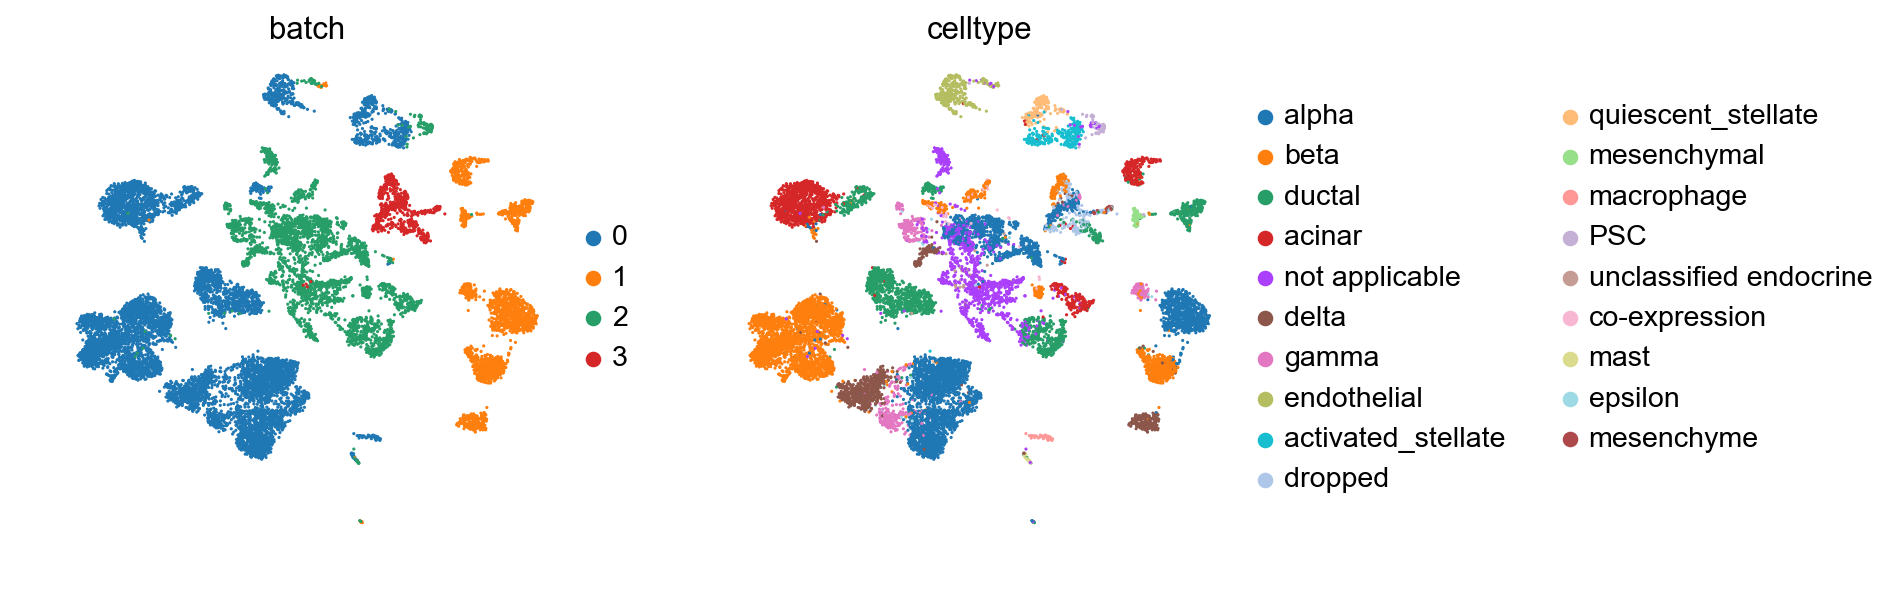

In [31]:
sc.pl.umap(adata_all, color=['batch', 'celltype'], palette=sc.pl.palettes.vega_20_scanpy)

### Mapping onto a reference batch

Choose one reference batch for training the model and setting up the neighborhood graph (here, a PCA) and separate out all other batches.

As before, the model trained on the reference batch will explain the biological variation observed within it.

In [32]:
adata_ref = adata_all[adata_all.obs.batch == '0']

Compute the PCA, neighbors and UMAP on the reference data.

In [33]:
sc.pp.pca(adata_ref)
sc.pp.neighbors(adata_ref)
sc.tl.umap(adata_ref)

The reference batch contains 12 of the 19 cell types across all batches.

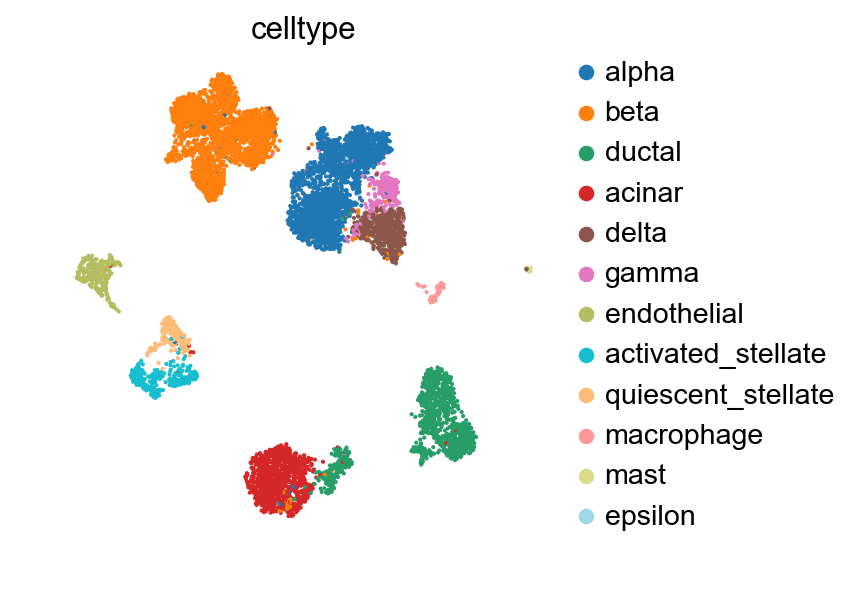

In [34]:
sc.pl.umap(adata_ref, color='celltype')

Iteratively map labels (such as 'celltype') and embeddings (such as 'X_pca' and 'X_umap') from the reference data onto the query batches.

In [35]:
adatas = [adata_all[adata_all.obs.batch == i].copy() for i in ['1', '2', '3']]

In [36]:
sc.settings.verbosity = 2  # a bit more logging
for iadata, adata in enumerate(adatas):
    print(f'... integrating batch {iadata+1}')
    adata.obs['celltype_orig'] = adata.obs.celltype  # save the original cell type
    sc.tl.ingest(adata, adata_ref, obs='celltype')

Trying to set attribute `.obs` of view, copying.


... integrating batch 1
running ingest
    finished (0:00:05)


Trying to set attribute `.obs` of view, copying.


... integrating batch 2
running ingest
    finished (0:00:04)


Trying to set attribute `.obs` of view, copying.


... integrating batch 3
running ingest
    finished (0:00:01)


Each of the query batches now carries annotation that has been contextualized with `adata_ref`. By concatenating, we can view it together.

In [37]:
adata_concat = adata_ref.concatenate(adatas)

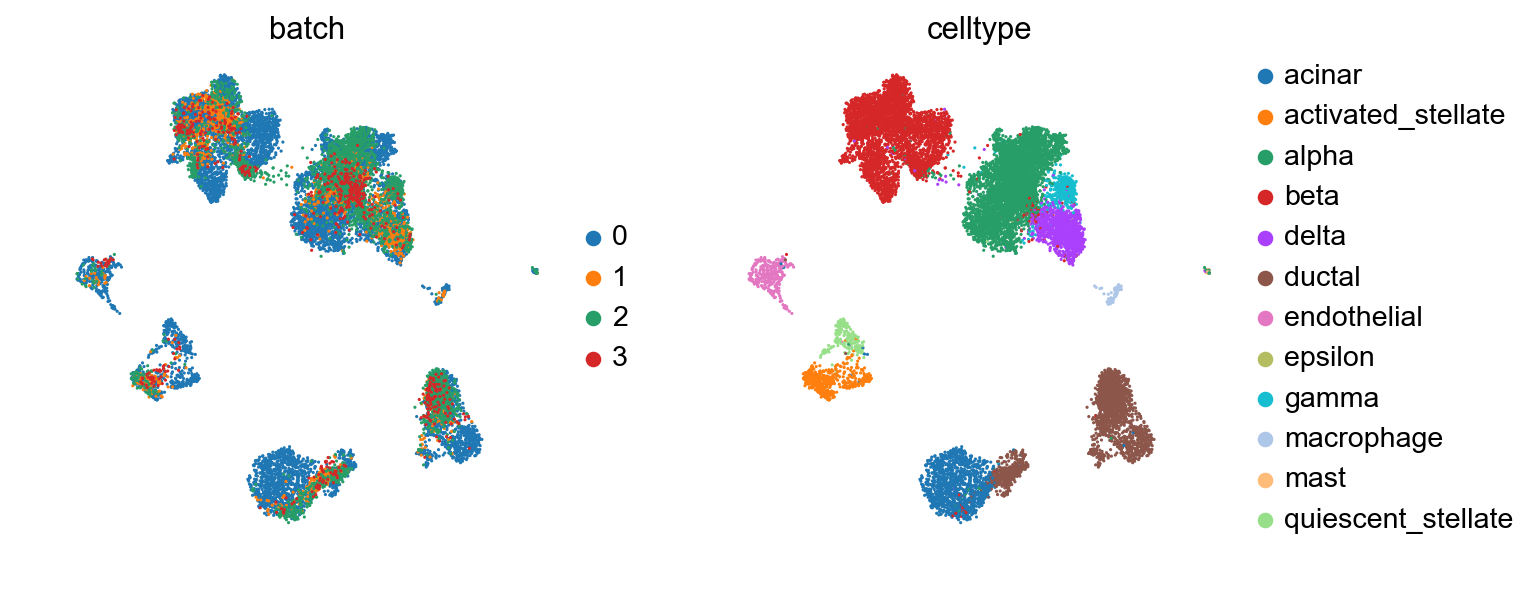

In [42]:
sc.pl.umap(adata_concat, color=['batch', 'celltype'])

### Evaluating consistency

Let us subset the data to the query batches.

In [48]:
adata_query = adata_concat[adata_concat.obs.batch.isin(['1', '2', '3'])]

The following plot is a bit hard to read, hence, move on to confusion matrices below.

/Users/alexwolf/repos/anndata/anndata/_core/anndata.py:1118: ImplicitModificationWarning: Initializing view as actual.
  "Initializing view as actual.", ImplicitModificationWarning,


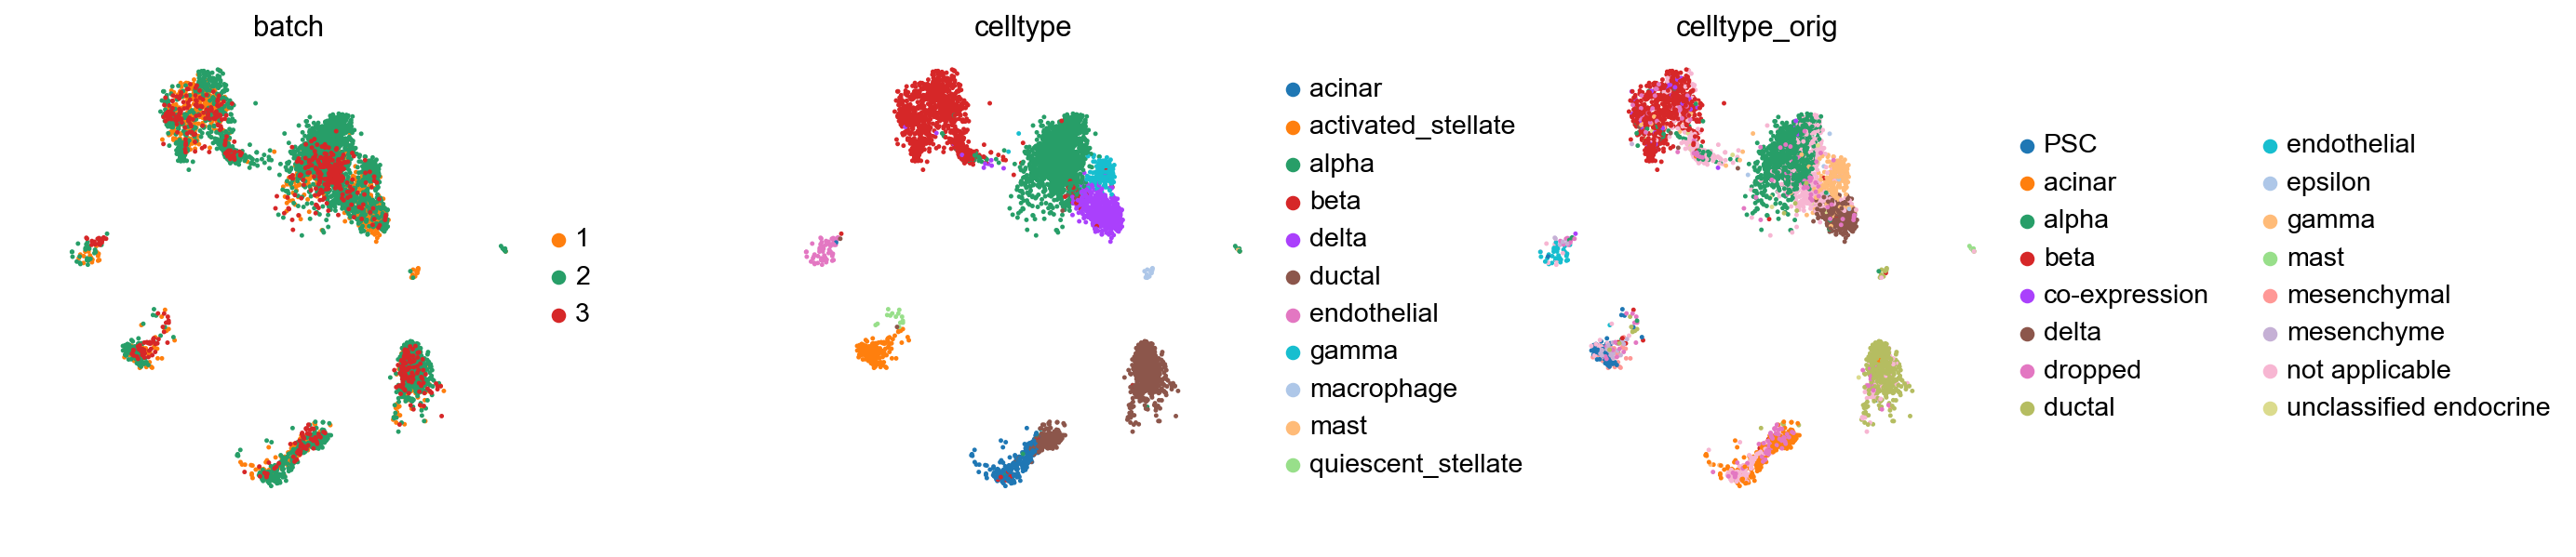

In [49]:
sc.pl.umap(
    adata_query, color=['batch', 'celltype', 'celltype_orig'], wspace=0.4)

#### Cell types conserved across batches

Let us first focus on cell types that are conserved with the reference, to simplify reading of the confusion matrix.

In [64]:
obs_query = adata_query.obs
conserved_categories = obs_query.celltype.cat.categories.intersection(obs_query.celltype_orig.cat.categories)
obs_query_conserved = obs_query.loc[obs_query.celltype.isin(conserved_categories) & obs_query.celltype_orig.isin(conserved_categories)]

In [65]:
pd.crosstab(obs_query_conserved.celltype, obs_query_conserved.celltype_orig)

celltype_orig,acinar,alpha,beta,delta,ductal,endothelial,gamma,mast
celltype,,,,,,,,
acinar,145,1,3,0,2,0,3,0
alpha,0,1819,3,1,7,0,20,5
beta,1,49,803,10,3,0,26,0
delta,0,5,4,305,0,0,73,0
ductal,263,8,5,0,693,0,0,0
endothelial,0,2,0,0,0,36,0,0
gamma,0,1,5,0,0,0,194,0
mast,0,0,0,0,1,0,0,2


Overall, the conserved cell types are also mapped as expected. The main exception are some acinar cells in the original annotation that appear as acinar cells. However, already the reference data is observed to feature a cluster of both acinar and ductal cells, which explains the discrepancy, and indicates a potential inconsistency in the initial annotation.

#### All cell types

Let us now move on to look at all cell types.

In [68]:
pd.crosstab(adata_query.obs.celltype, adata_query.obs.celltype_orig)

celltype_orig,PSC,acinar,alpha,beta,co-expression,delta,dropped,ductal,endothelial,epsilon,gamma,mast,mesenchymal,mesenchyme,not applicable,unclassified endocrine
celltype,,,,,,,,,,,,,,,,
acinar,0,145,1,3,0,0,25,2,0,0,3,0,0,0,86,0
activated_stellate,49,1,1,4,0,0,11,8,0,0,0,0,79,20,17,0
alpha,0,0,1819,3,2,1,33,7,0,3,20,5,0,0,305,11
beta,0,1,49,803,36,10,42,3,0,1,26,0,0,1,522,24
delta,0,0,5,4,1,305,12,0,0,5,73,0,0,0,94,5
ductal,0,263,8,5,0,0,41,693,0,0,0,0,1,0,106,1
endothelial,1,0,2,0,0,0,7,0,36,0,0,0,0,6,7,0
gamma,0,0,1,5,0,0,2,0,0,1,194,0,0,0,14,0
macrophage,0,0,1,1,0,0,0,12,0,0,0,0,0,0,1,0


We observe that PSC ([pancreatic stellate cells](https://en.wikipedia.org/wiki/Pancreatic_stellate_cell)) cells are in fact just inconsistently annotated and correctly mapped on 'activated_stellate' cells.

Also, it's nice to see that 'mesenchyme' and 'mesenchymal' cells both map onto the same category. However, that category is again 'activated_stellate' and likely incorrect.

### Visualizing distributions across batches

Often, batches correspond to experiments that one wants to compare. Scanpy offers to convenient visualization possibilities for this.

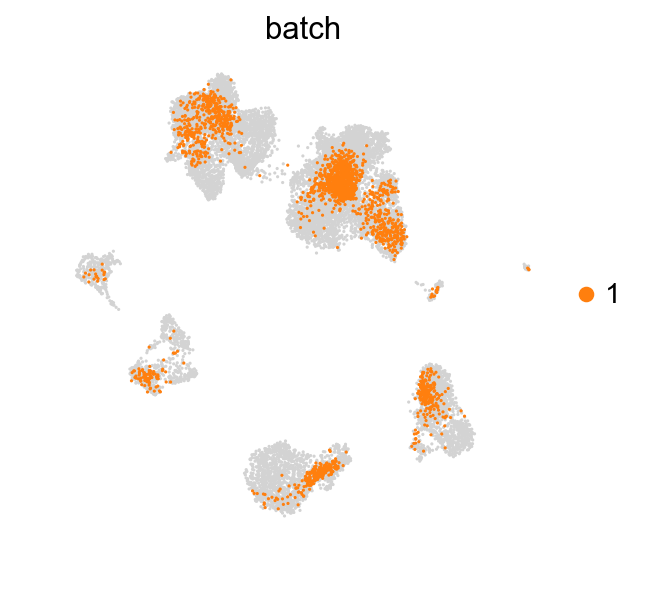

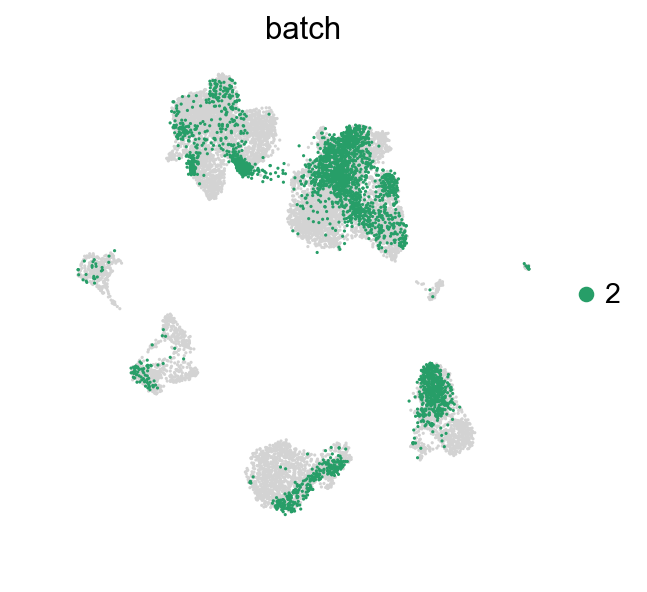

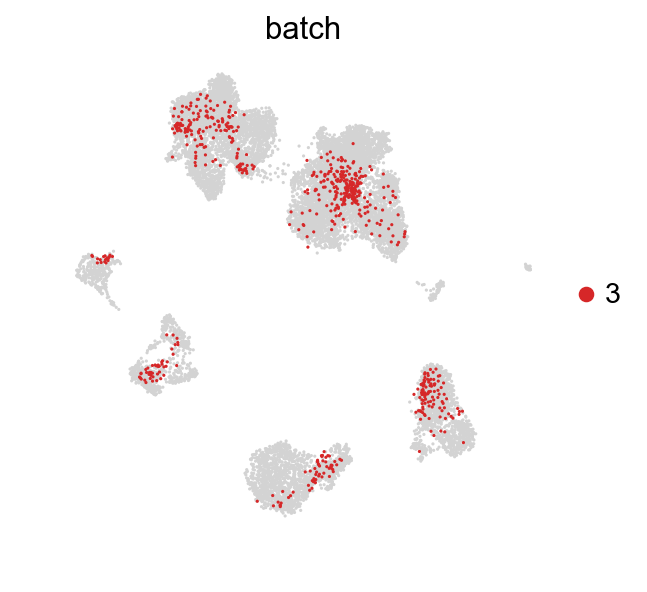

In [66]:
for batch in ['1', '2', '3']:
    sc.pl.umap(adata_concat, color='batch', groups=[batch])